In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
%matplotlib inline

from __future__ import division

#### Stock Name and Source

For more information on available sources:
http://pandas-datareader.readthedocs.io/en/latest/remote_data.html

In [57]:
stock = 'AAPL'
source = 'yahoo'

#### Set start and end date

In [58]:
end = datetime.datetime.today()
start = datetime.datetime(2000,1,1)

In [59]:
f = web.DataReader(stock, source, start, end)

# Let's clear NaN rows
f = f.dropna()

# Data Preview

In [60]:
f.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,3.604911,3.674107,3.553571,3.671875,3.291592,40952800
2000-01-03,3.745536,4.017857,3.631696,3.997768,3.583733,133949200
2000-01-04,3.866071,3.950893,3.613839,3.660714,3.281587,128094400
2000-01-05,3.705357,3.948661,3.678571,3.714286,3.329610,194580400
2000-01-06,3.790179,3.821429,3.392857,3.392857,3.041471,191993200


# Pre-processing

### Get daily returns

In [61]:
daily_ret = f.copy()

In [62]:
daily_ret['Close Pct Change'] = f.Close.pct_change()
daily_ret['Adj Close Pct Change'] = f['Adj Close'].pct_change()

In [63]:
daily_ret.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [64]:
daily_ret.dropna(axis = 0, how='any', inplace=True)
daily_ret.head()

,Close Pct Change,Adj Close Pct Change
Date,,
2000-01-03,0.088754,0.088754
2000-01-04,-0.084311,-0.084310
2000-01-05,0.014634,0.014634
2000-01-06,-0.086539,-0.086538
2000-01-07,0.047368,0.047368


# General Statistics

In [65]:
daily_ret.describe()

,Close Pct Change,Adj Close Pct Change
count,4498.000000,4498.000000
mean,0.001213,0.001238
std,0.026245,0.026241
min,-0.518692,-0.518692
25%,-0.010887,-0.010857
50%,0.000770,0.000863
75%,0.013346,0.013346
max,0.139050,0.139050


In [66]:
daily_ret['Close Pct Change'].autocorr(lag=1)

-0.03319288570651361

# Rolling Statistics

In [67]:
rolling = daily_ret.copy()

### Rolling Means 30 Period

In [68]:
rolling['Rolling Mean 30 Periods'] = rolling['Close Pct Change'].rolling(30).mean()

In [69]:
rolling['Rolling Mean 30 Periods'].describe()

count    4469.000000
mean        0.001204
std         0.004791
min        -0.031093
25%        -0.001079
50%         0.001538
75%         0.003983
max         0.016542
Name: Rolling Mean 30 Periods, dtype: float64

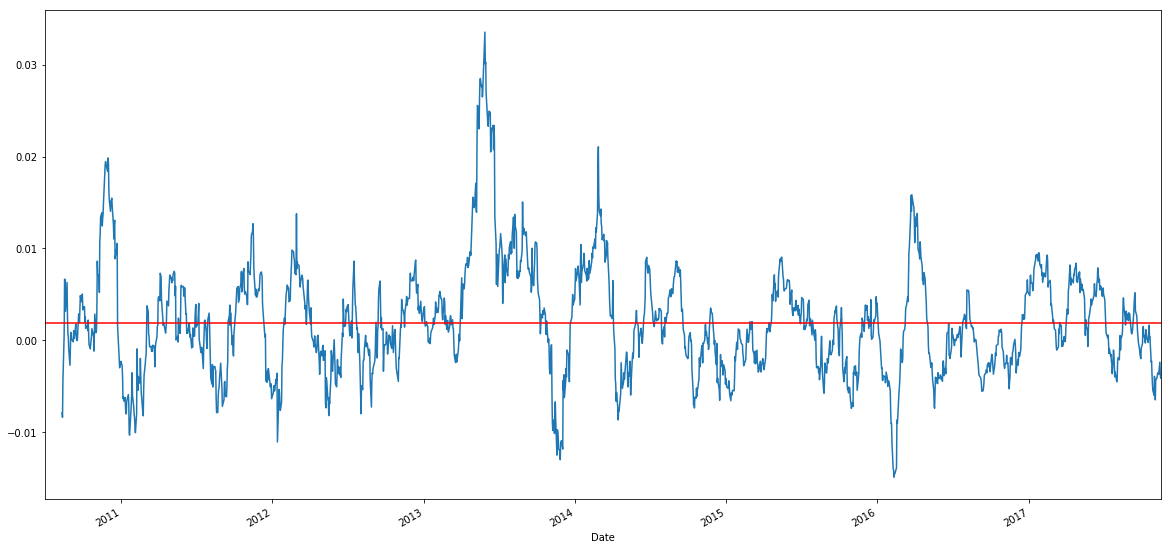

In [41]:
rolling['Rolling Mean 30 Periods'].plot(figsize=(20,10))
plt.axhline(rolling['Close Pct Change'].mean(), color='r')

### Rolling STDEV 30 periods

In [70]:
rolling['Rolling STD 30 Periods'] = rolling['Close Pct Change'].rolling(30).std()

In [71]:
rolling['Rolling STD 30 Periods'].describe()

count    4469.000000
mean        0.023028
std         0.012306
min         0.005085
25%         0.014552
50%         0.020204
75%         0.028318
max         0.107681
Name: Rolling STD 30 Periods, dtype: float64

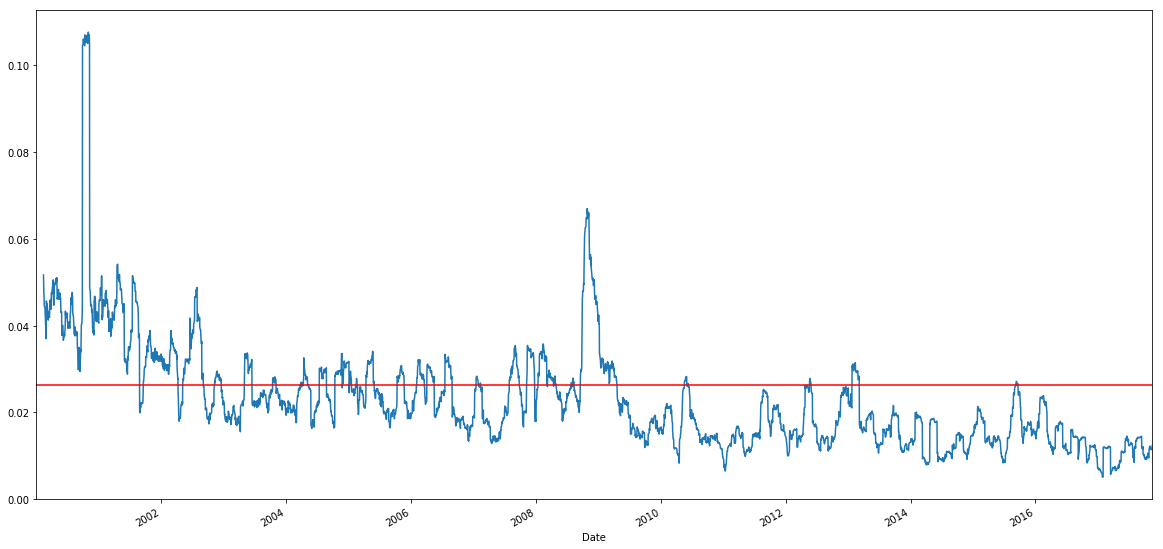

In [72]:
rolling['Rolling STD 30 Periods'].plot(figsize=(20,10))
plt.axhline(rolling['Close Pct Change'].std(), color='r')

### Rolling Auto-Correlation (Lag = 1) 30 periods

In [73]:
rolling['Rolling AutoCorr 30 periods'] = rolling['Close Pct Change'].rolling(
    center=False,window=30).apply(func=lambda x: pd.Series(x).autocorr(1))

In [74]:
rolling['Rolling AutoCorr 30 periods'].describe()

count    4469.000000
mean       -0.033263
std         0.162392
min        -0.618893
25%        -0.140226
50%        -0.034620
75%         0.061006
max         0.528201
Name: Rolling AutoCorr 30 periods, dtype: float64

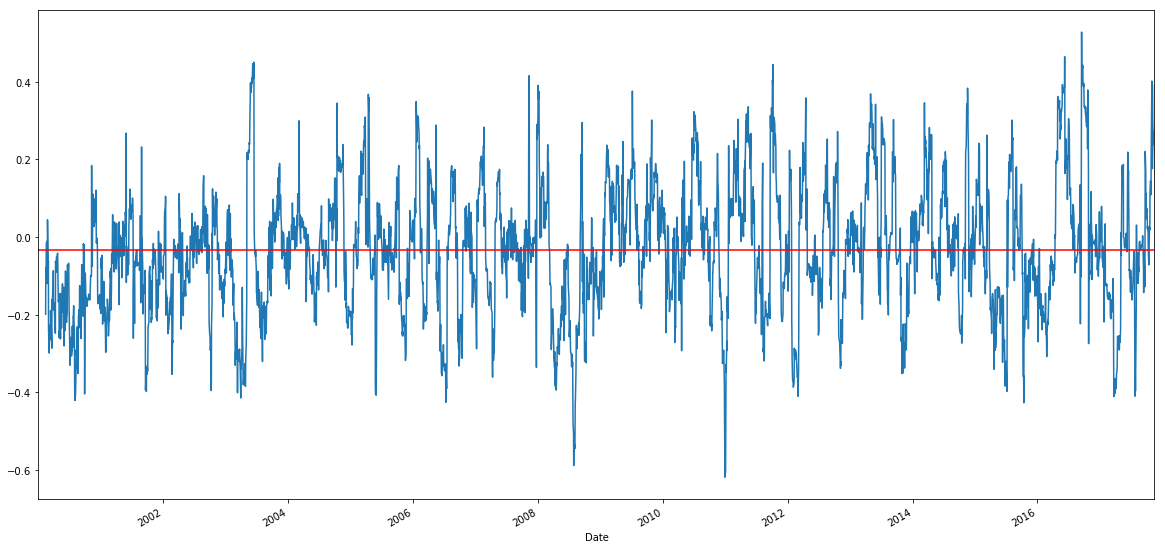

In [75]:
rolling['Rolling AutoCorr 30 periods'].plot(figsize=(20,10))
plt.axhline(rolling['Close Pct Change'].autocorr(1), color='r')

# Simple Monte Carlo

In [95]:
start_price = f.tail(1).Close[0]
days = 250
mu = rolling['Close Pct Change'].mean()
sigma = rolling['Close Pct Change'].std()
dt = 1/days

def stock_monte_carlo(start_price, days, mu, sigma):
    price = np.zeros(days)
    price[0] = start_price
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in xrange(1, days):
        shock[x] = np.random.normal(loc=mu*dt, scale=sigma*np.sqrt(dt))
        drift[x] = mu*dt
        price[x] = price[x-1]+(price[x-1]*(drift[x]+shock[x]))
    return price

Text(0.5,1,u'Monte Carlo Analysis')

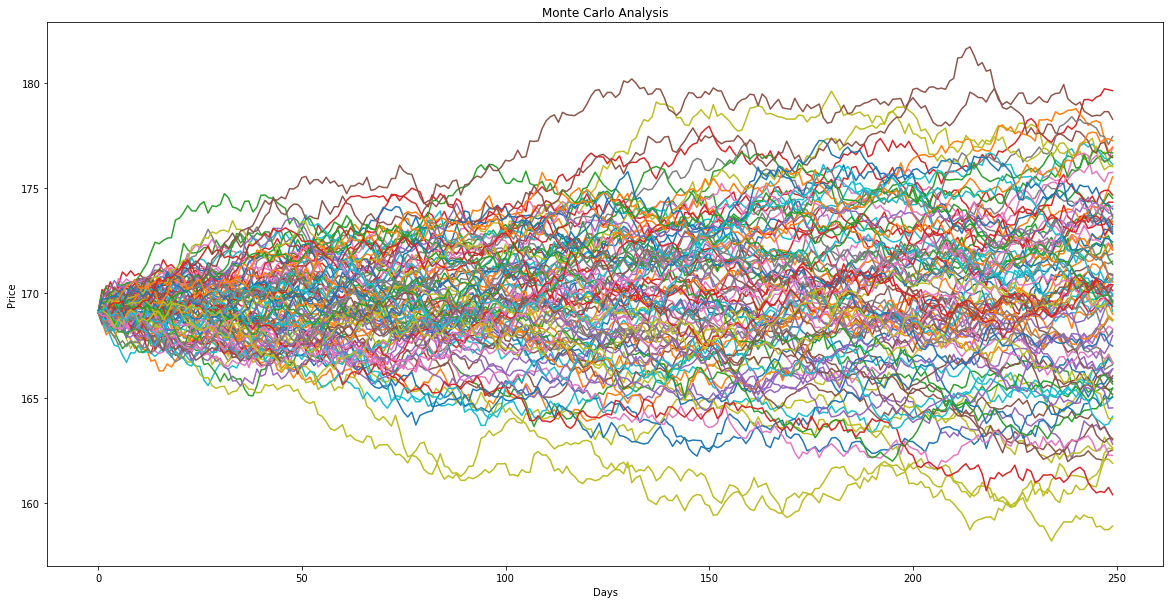

In [99]:
plt.figure(figsize=(20,10))
for run in xrange(100):
    plt.plot(stock_monte_carlo(start_price, days, mu, sigma))
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis')

In [100]:
runs = 10000

simulations = np.zeros(runs)

for run in xrange(runs):
    simulations[run] = stock_monte_carlo(start_price, days, mu, sigma)[days-1]

Text(0.5,1,u'Final price distribution after 250 days')

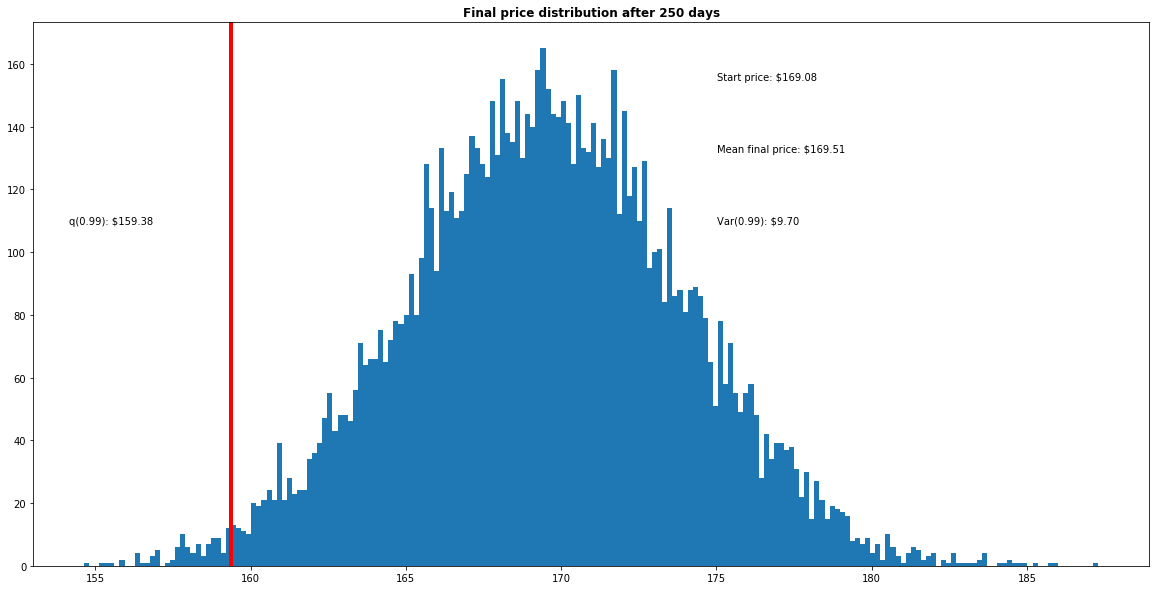

In [102]:
q = np.percentile(simulations, 1)
plt.figure(figsize=(20,10))
plt.hist(simulations, bins=200)
plt.figtext(0.6, 0.8, s='Start price: $%.2f' % start_price)
plt.figtext(0.6,0.7,'Mean final price: $%.2f' % simulations.mean())
plt.figtext(0.6,0.6,'Var(0.99): $%.2f' % (start_price - q))
plt.figtext(0.15,0.6,'q(0.99): $%.2f' % q)
plt.axvline(x=q, linewidth=4, color='r')
plt.title(u'Final price distribution after %s days' % days, weight='bold')